# Negative Control Experiment

This section shows the p-value distributions of 100 GTex samples when different background datasets are used in the model. Comparing normal samples to other normals should result in a posterior predictive p-value distribution that is peaked around 0.5 (centered). Ergo, there should be far fewer outliers when GTEx and TCGA-normal are the backgrounds compared to TCGA-tumor. We expect the p-value distribution when tumor is the background to have longer tails that extend below 0.05 and above 0.95.

In [16]:
import pandas as pd
import numpy as np
import os

## Randomly select samples

In [14]:
tissues = ["Adrenal", "Bladder", "Brain", "Breast", "Kidney", 
           "Liver", "Lung", "Prostate", "Stomach", "Thyroid"]
gtex = pd.read_hdf('/mnt/data/outlier/gtex.hd5')

In [19]:
samples = {}
for tissue in tissues:
    gtex_samples = list(gtex[gtex.tissue == tissue].index)
    samples[tissue] = list(np.random.choice(gtex_samples, 10))

## Create manifest

In [22]:
manifest_out = '/mnt/normsd-outlier-runs/negative-control/manifest.tsv'
output_path = '/mnt/out'
with open(manifest_out, 'w') as f:
    f.write('sample\tbackground\tout_dir\n')
    for k, v in samples.items():
        for background in ['gtex', 'tumor', 'normal']:
            background_path = f'/mnt/inputs/{background}.hd5'
            experiment_dir = 'mnt/outputs/norm-sd-runs/negative-control'
            out_path = os.path.join(experiment_dir, background)
            for sample in v:
                f.write(f'{sample}\t{background_path}\t{out_path}\n')

## Run Samples

```
#!/usr/bin/env bash
source activate toil
python toil-outlier-detection.py \
    --sample /mnt/inputs/gtex.hd5 \
    --background /mnt/inputs/gtex.hd5 \
    --manifest /mnt/inputs/norm-sd-runs/negative-control/manifest.tsv \
    --out-dir /mnt/outputs/norm-sd-runs/negative-control/ \
    --gene-list /mnt/inputs/drug-genes.txt \
    --group tissue \
    --col-skip 5 \
    --num-backgrounds 4 \
    --max-genes 125 \
    --workDir /mnt/ \
    --disable-iter \
    /mnt/jobStore
```

## Analysis

In [94]:
class Outliers:
    def __init__(self, sample_dir, sample_path):
        self.sample_dir = sample_dir
        self.sample_path = sample_path
        self.df = self._load_df(sample_path)
        self.tissue = self.df.tissue
        self.pval_df = self._pval_df()

    def _pval_df(self) -> pd.DataFrame:
        pvals = []
        for dataset in os.listdir(self.sample_dir):
            if dataset == 'manifest.tsv':
                continue
            for sample_name in os.listdir(os.path.join(self.sample_dir, dataset)):
                sample_path = os.path.join(self.sample_dir, dataset, sample_name)
                pval_path = os.path.join(sample_path, "pvals.tsv")
                p = pd.read_csv(pval_path, sep="\t")
                p["sample"] = sample_name
                p["tissue"] = self.tissue.loc[sample_name]
                p["dataset"] = dataset.capitalize()
                pvals.append(p)
        pvals = pd.concat(pvals)
        return pvals.sort_values("tissue").reset_index(drop=True)

    @staticmethod
    def _load_df(path):
        """Loads DataFrame"""
        print(f"Reading in {path}")
        if path.endswith(".csv"):
            df = pd.read_csv(path, index_col=0)
        elif path.endswith(".tsv"):
            df = pd.read_csv(path, sep="\t", index_col=0)
        else:
            try:
                df = pd.read_hdf(path)
            except Exception as e:
                print(e)
                raise RuntimeError(f"Failed to open DataFrame: {path}")
        return df


In [95]:
o = Outliers(
    sample_dir='/mnt/normsd-outlier-runs/negative-control/',
    sample_path='/mnt/data/outlier/gtex.hd5'
)

Reading in /mnt/data/outlier/gtex.hd5


In [96]:
drug_path = '/mnt/data/outlier/drug-genes.txt'
drug_genes = sorted([x.strip() for x in open(drug_path).readlines()])

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.25)
sns.set_style('whitegrid')

In [109]:
pdf = o.pval_df
pdf = pdf[pdf.Gene.isin(drug_genes)]
pdf = pdf.sort_values(['tissue', 'dataset'])
pdf.head()

,Gene,Pval,sample,tissue,dataset
56,MAP2K1,0.359,GTEX-R53T-0226-SM-48FEH,Adrenal,Gtex
57,MTOR,0.359,GTEX-R53T-0226-SM-48FEH,Adrenal,Gtex
58,HSP90AB1,0.363,GTEX-R53T-0226-SM-48FEH,Adrenal,Gtex
59,FGFR4,0.370,GTEX-R53T-0226-SM-48FEH,Adrenal,Gtex
60,PIK3CD,0.377,GTEX-R53T-0226-SM-48FEH,Adrenal,Gtex


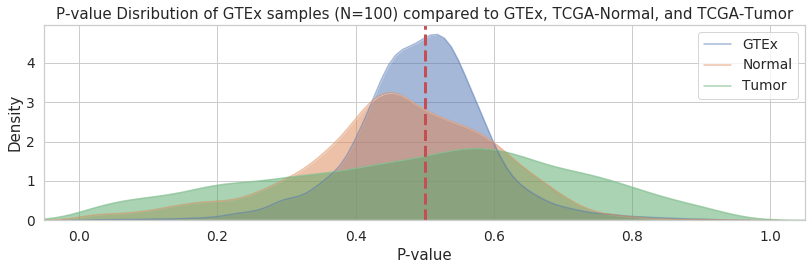

In [132]:
plt.figure(figsize=(12, 4))
sns.kdeplot(pdf[pdf.dataset == 'Gtex'].Pval, label='GTEx', alpha=0.5, shade=True)
sns.kdeplot(pdf[pdf.dataset == 'Normal'].Pval, label='Normal', alpha=0.5, shade=True)
sns.kdeplot(pdf[pdf.dataset == 'Tumor'].Pval, label='Tumor', alpha=0.5, shade=True)
plt.title('P-value Disribution of GTEx samples (N=100) '
          'compared to GTEx, TCGA-Normal, and TCGA-Tumor')
plt.xlabel('P-value')
plt.ylabel('Density')
plt.axvline(0.5, ls='--', c='r', lw=3)
plt.xlim([-0.05, 1.05])
plt.tight_layout()
plt.savefig(
    '/mnt/figures/negative-control/pval-dist.png',
    dpi=300, 
    transparent=True
)

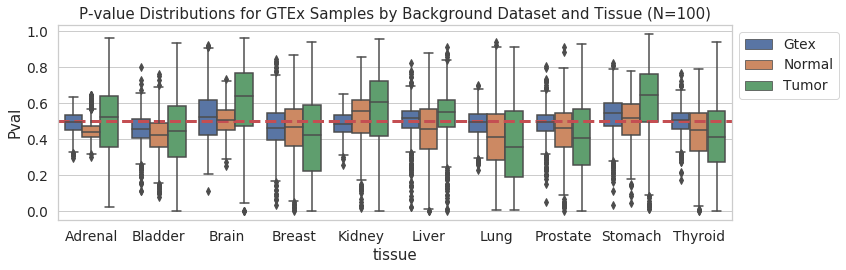

In [119]:
plt.figure(figsize=(12, 4))
plt.axhline(0.5, c='r', ls='--', lw=3)
sns.boxplot(data=pdf, x='tissue', y='Pval', hue='dataset')
plt.legend(bbox_to_anchor=[1, 1])
plt.title('P-value Distributions for GTEx Samples by \
        Background Dataset and Tissue (N=100)');
plt.tight_layout()
plt.savefig(
    '/mnt/figures/negative-control/pval-dist-boxplot.png',
    dpi=300, 
    transparent=True
)